In [14]:
#!wget "https://github.com/dArK-sEiD05/files/blob/main/loan_data.xlsx" -O loan_data.xlsx

--2025-08-19 02:52:18--  https://github.com/dArK-sEiD05/files/blob/main/loan_data.xlsx
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘loan_data.xlsx’

loan_data.xlsx          [ <=>                ] 179.15K  --.-KB/s    in 0.03s   

2025-08-19 02:52:18 (6.66 MB/s) - ‘loan_data.xlsx’ saved [183448]



In [85]:
#importing modeules
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (

    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
import joblib
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from tensorflow.keras.regularizers import l2
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
from sklearn.impute import SimpleImputer
from xgboost import plot_importance
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve






In [2]:
df = pd.read_excel("loan_data.xlsx")

/tmp/ipython-input-3799860465.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Default", data=df, palette="pastel")


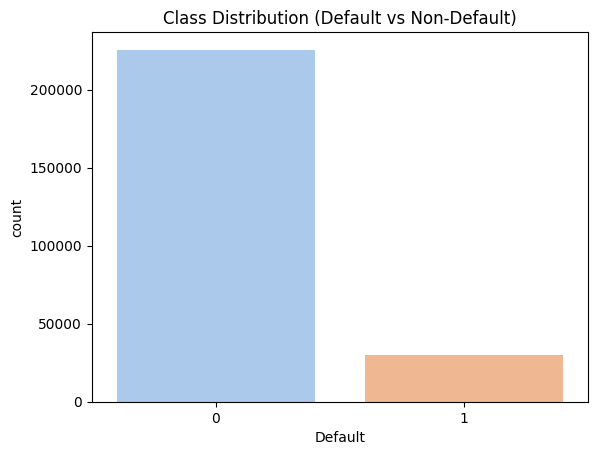

In [3]:


sns.countplot(x="Default", data=df, palette="pastel")
plt.title("Class Distribution (Default vs Non-Default)")
plt.show()


In [4]:
print(df["Default"].value_counts())

Default
0    225602
1     29644
Name: count, dtype: int64


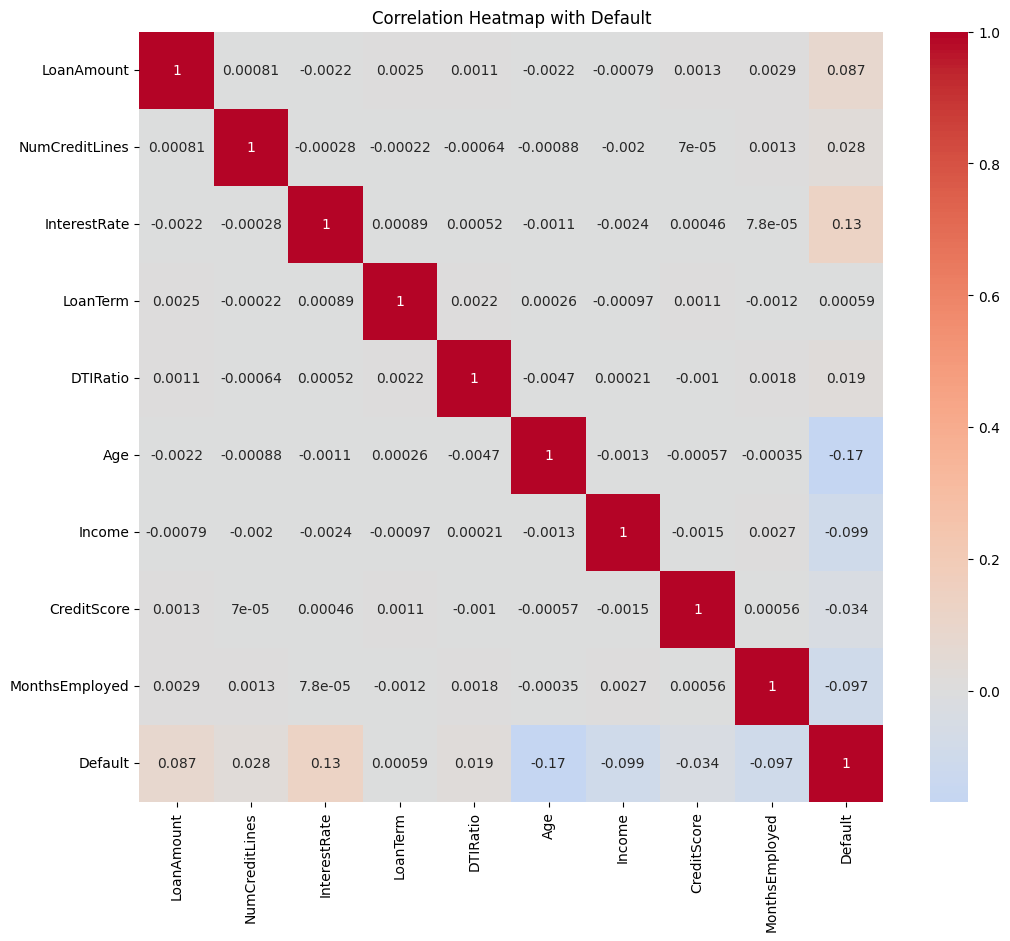

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visuals


numerical_features = [
     'LoanAmount',
    'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio',
    'Age', 'Income', 'CreditScore', 'MonthsEmployed'
]
numerical_features = [f for f in numerical_features if f in df.columns]



# Correlation Heatmap (Numerical Features + Default)
correlation_cols = numerical_features + ['Default']
plt.figure(figsize=(12, 10))
sns.heatmap(df[correlation_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap with Default')
plt.savefig('correlation_heatmap.png')
plt.show()


In [5]:
value_counts = df['EmploymentType'].value_counts()
print(value_counts)

EmploymentType
Part-time        64131
Unemployed       63799
Self-employed    63680
Full-time        63636
Name: count, dtype: int64


In [6]:
# Impute categorical columns with mode
cat_cols = ['LoanPurpose', 'HasDependents', 'HasMortgage', 'HasCoSigner']
cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# Impute numeric columns (as you did)
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Only drop rows if absolutely necessary (e.g., missing target)
df.dropna(subset=['Default'], inplace=True)



# Feature engineering
df['AgeRisk'] = np.where((df['Age'] < 25) | (df['Age'] > 60), 1, 0)
df['IncomeRisk'] = df['Income'].max() - df['Income']
df['CreditScoreRisk'] = df['CreditScore'].max() - df['CreditScore']
df['MonthsEmployedRisk'] = df['MonthsEmployed'].max() - df['MonthsEmployed']


# --- Feature 1: MonthlyPayment and PaymentToIncome ---
r = df['InterestRate'] / 100.0 / 12.0  # monthly rate
n = df['LoanTerm'].replace(0, 1)       # guard zero term
P = df['LoanAmount']
# handle zero interest separately to avoid division by zero
df['MonthlyPayment'] = np.where(
    np.isclose(r, 0),
    P / n,
    P * r / (1 - (1 + r) ** (-n))
)
df['PaymentToIncome'] = df['MonthlyPayment'] / (df['Income'] / 12 + 1e-9)

# --- Feature 2: CreditScore_bin (and numeric encoding) ---
bins = [0, 580, 670, 740, 800, 1000]
labels = ['poor','fair','avg','good','excellent']
df['CreditScore_bin'] = pd.cut(df['CreditScore'], bins=bins, labels=labels, include_lowest=True)
ord_map = {'poor':0,'fair':1,'avg':2,'good':3,'excellent':4}
df['CreditScore_num'] = df['CreditScore_bin'].map(ord_map).astype(float).fillna(df['CreditScore'].median())

# --- Feature 3: EmploymentStabilityFlag ---
df['EmploymentYears'] = df['MonthsEmployed'] / 12.0
df['EmploymentStabilityFlag'] = (df['MonthsEmployed'] < 12).astype(int)


df = pd.get_dummies(df, columns=['EmploymentType'], prefix='Emp', dtype=int)

categorical_cols = ["HasMortgage", "HasDependents","HasCoSigner"]
for col in categorical_cols:
    df[col] = df[col].map({"Yes": 1, "No": 0})




,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,MonthlyPayment,PaymentToIncome,CreditScore_bin,CreditScore_num,EmploymentYears,EmploymentStabilityFlag,Emp_Full-time,Emp_Part-time,Emp_Self-employed,Emp_Unemployed
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,...,1759.318045,0.245503,poor,0.0,6.666667,0,1,0,0,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,...,2337.519546,0.556199,poor,0.0,1.250000,0,1,0,0,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,...,6649.201648,0.947540,poor,0.0,2.166667,0,0,0,0,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,...,2007.188719,0.759508,good,3.0,0.000000,1,1,0,0,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,...,216.773108,0.127283,fair,1.0,0.666667,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255241,SNJ7HKIR0P,62,110669,232758,765,118,2,10.20,24,0.85,...,10762.099300,1.166950,good,3.0,9.833333,0,0,0,1,0
255242,PRF588IALO,55,122177,41708,308,51,1,8.93,24,0.35,...,1904.079963,0.187015,poor,0.0,4.250000,0,0,0,1,0
255243,EONXGLYH2P,34,32274,171432,436,110,3,6.15,24,0.68,...,7609.563129,2.829360,poor,0.0,9.166667,0,0,0,1,0
255244,WAR5W2QB6M,28,137827,122232,374,65,1,9.72,36,0.46,...,3928.033935,0.341997,poor,0.0,5.416667,0,1,0,0,0


In [7]:
features = [
    'IncomeRisk', 'LoanAmount', 'CreditScoreRisk', 'MonthsEmployedRisk',
    'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio',
    'HasMortgage', 'HasCoSigner', 'AgeRisk', 'HasDependents',
    'Emp_Full-time', 'Emp_Self-employed', 'Emp_Unemployed', 'Emp_Part-time','PaymentToIncome','CreditScore_num','EmploymentStabilityFlag'
]

In [48]:
X = df[features]
y = df["Default"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [70]:
smote = SMOTE(sampling_strategy=0.3)  # only balance partially
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())

Before SMOTE: Default
0    157921
1     20751
Name: count, dtype: int64
After SMOTE: Default
0    157921
1     47376
Name: count, dtype: int64


In [71]:
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # keep 0s twice as many as 1s
X_res, y_res = rus.fit_resample(X_train_res, y_train_res)



print("Before sampling:", y_train_res.value_counts())
print("After sample:", y_res.value_counts())

Before sampling: Default
0    157921
1     47376
Name: count, dtype: int64
After sample: Default
0    94752
1    47376
Name: count, dtype: int64


In [58]:
# Train Logistic Regression with class_weight balanced
model = LogisticRegression(max_iter=1500, class_weight="balanced")
model.fit(X_res, y_res)

# Predictions
y_pred = model.predict(X_test_scaled)

# Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test,y_pred))

[[43977 23704]
 [ 3105  5788]]
              precision    recall  f1-score   support

           0       0.93      0.65      0.77     67681
           1       0.20      0.65      0.30      8893

    accuracy                           0.65     76574
   macro avg       0.57      0.65      0.53     76574
weighted avg       0.85      0.65      0.71     76574

ROC-AUC Score: 0.6503088752688122
Accuracy:  0.6498942199702249


In [59]:
svm_model = LinearSVC( class_weight='balanced',  random_state=42)
svm_model.fit(X_train_res, y_train_res)

# SVM predictions
svm_y_pred = svm_model.predict(X_test_scaled)


# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, svm_y_pred))
print("\nClassification Report:\n", classification_report(y_test, svm_y_pred))
print("Accuracy: ", accuracy_score(y_test,y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Confusion Matrix:
 [[43906 23775]
 [ 3100  5793]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.65      0.77     67681
           1       0.20      0.65      0.30      8893

    accuracy                           0.65     76574
   macro avg       0.56      0.65      0.53     76574
weighted avg       0.85      0.65      0.71     76574

Accuracy:  0.6498942199702249
Precision: 0.1962566119625661
Recall: 0.6508489823456651
F1 Score: 0.3015761365116582


In [79]:
xgb_model = XGBClassifier(
    n_estimators=500,

    learning_rate=0.05,

    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=1.7,
    max_delta_step=1,
    eval_metric='auc',
    objective='binary:logistic'


)
X_res_df = pd.DataFrame(X_res, columns=features)
# Train model
xgb_model.fit(X_res_df, y_res)


y_pred = xgb_model.predict(X_test_scaled)
y_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]


# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:59:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
 [[62489  5192]
 [ 6569  2324]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91     67681
           1       0.31      0.26      0.28      8893

    accuracy                           0.85     76574
   macro avg       0.61      0.59      0.60     76574
weighted avg       0.84      0.85      0.84     76574



In [87]:
metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'classification_report': classification_report(y_test, y_pred, output_dict=True),
    'roc_auc': roc_auc_score(y_test, y_prob),
    'confusion_matrix': confusion_matrix(y_test, y_pred).tolist()
}
print("Model Metrics:", metrics)
os.makedirs("artifacts", exist_ok=True)
# Save model and artifacts
joblib.dump(xgb_model, 'artifacts/xgb_model.joblib')
joblib.dump(metrics, 'artifacts/model_metrics.joblib')
joblib.dump(y_test, 'artifacts/y_test.joblib')
joblib.dump(y_prob, 'artifacts/y_prob.joblib')

Model Metrics: {'accuracy': 0.8464100086191135, 'classification_report': {'0': {'precision': 0.904877059862724, 'recall': 0.9232871854730279, 'f1-score': 0.9139894251091496, 'support': 67681.0}, '1': {'precision': 0.30920702501330494, 'recall': 0.26132913527493534, 'f1-score': 0.2832591870315071, 'support': 8893.0}, 'accuracy': 0.8464100086191135, 'macro avg': {'precision': 0.6070420424380145, 'recall': 0.5923081603739816, 'f1-score': 0.5986243060703283, 'support': 76574.0}, 'weighted avg': {'precision': 0.8356983096352854, 'recall': 0.8464100086191135, 'f1-score': 0.8407389222331803, 'support': 76574.0}}, 'roc_auc': np.float64(0.6990234612641237), 'confusion_matrix': [[62489, 5192], [6569, 2324]]}


['artifacts/y_prob.joblib']

In [91]:
import shutil

shutil.make_archive("artifacts_backup", 'zip', "artifacts")

'/content/artifacts_backup.zip'

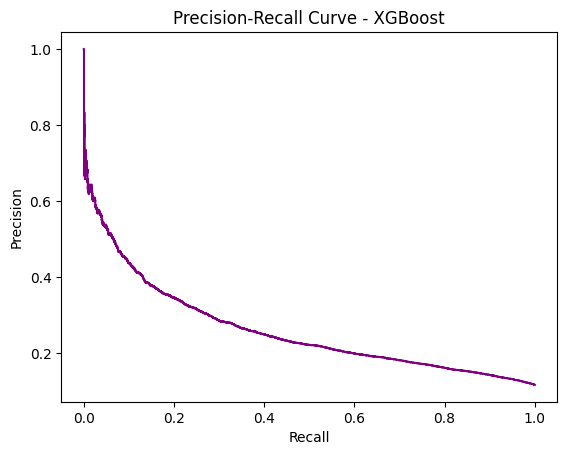

In [88]:

prec, rec, _ = precision_recall_curve(y_test, y_prob)
plt.plot(rec, prec, color="purple")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - XGBoost")
plt.show()

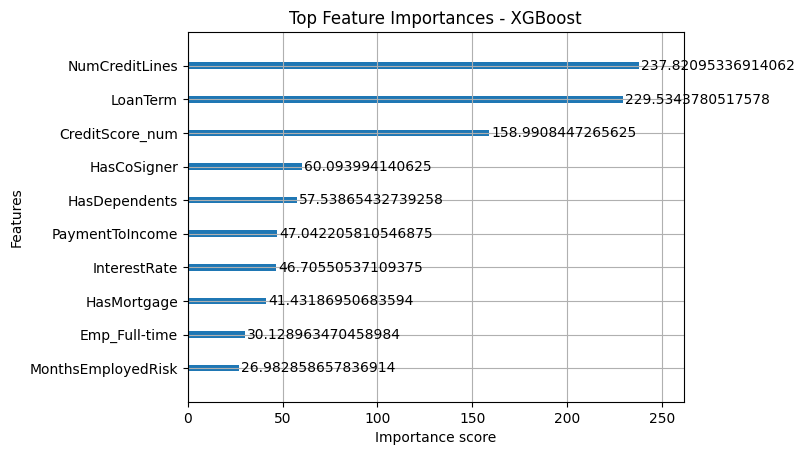

In [89]:
plot_importance(xgb_model, max_num_features=10, importance_type="gain")
plt.title("Top Feature Importances - XGBoost")
plt.show()

/tmp/ipython-input-19683943.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_summary = df_risk.groupby("RiskSegment")["y_true"].mean().reset_index()


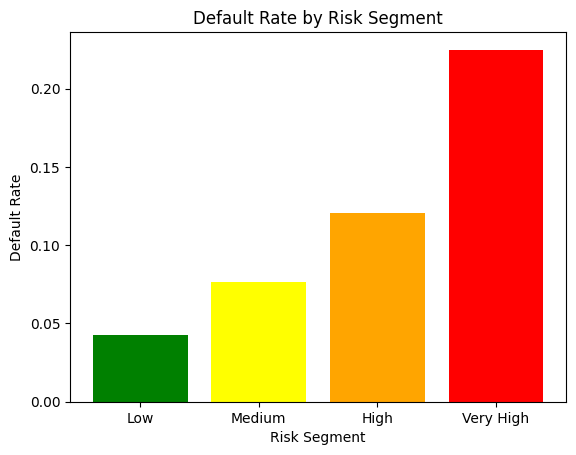

In [90]:
# Create a DataFrame with true labels and predicted probability
df_risk = pd.DataFrame({"y_true": y_test, "y_prob": y_prob})

# Segment into 4 risk groups (quartiles)
df_risk["RiskSegment"] = pd.qcut(df_risk["y_prob"], q=4, labels=["Low", "Medium", "High", "Very High"])

# Calculate default rate in each segment
risk_summary = df_risk.groupby("RiskSegment")["y_true"].mean().reset_index()

# Plot
plt.bar(risk_summary["RiskSegment"], risk_summary["y_true"], color=["green","yellow","orange","red"])
plt.xlabel("Risk Segment")
plt.ylabel("Default Rate")
plt.title("Default Rate by Risk Segment")
plt.show()

In [64]:
model=RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_res, y_res)

# Predictions

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))
print("accuracy score",accuracy_score(y_test,y_pred))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Confusion Matrix:
 [[ 2761 64920]
 [  236  8657]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.04      0.08     67681
           1       0.12      0.97      0.21      8893

    accuracy                           0.15     76574
   macro avg       0.52      0.51      0.14     76574
weighted avg       0.83      0.15      0.09     76574

ROC-AUC Score: 0.5686315294598597
accuracy score 0.1491106641941129


In [67]:
model = Sequential([
   Dense(32, activation="relu", kernel_regularizer=l2(0.001), input_shape=(X_res.shape[1],)),
    Dropout(0.3),
    Dense(16, activation="relu", kernel_regularizer=l2(0.001)),
    Dense(1, activation="sigmoid")

])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

# Train model
history = model.fit(X_res, y_res, validation_data=(X_test_scaled, y_test),
                    epochs=10, batch_size=32, verbose=1)

# Predictions
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluation Metrics
print("classification report",classification_report(y_test, y_pred))

print("confusion matrix",confusion_matrix(y_test,y_pred))

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3702/3702 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6826 - auc_1: 0.6648 - loss: 0.6281 - val_accuracy: 0.8407 - val_auc_1: 0.7071 - val_loss: 0.4473
Epoch 2/10
3702/3702 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.7004 - auc_1: 0.7072 - loss: 0.5831 - val_accuracy: 0.8400 - val_auc_1: 0.7074 - val_loss: 0.4497
Epoch 3/10
3702/3702 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.6994 - auc_1: 0.7075 - loss: 0.5805 - val_accuracy: 0.8442 - val_auc_1: 0.7073 - val_loss: 0.4443
Epoch 4/10
3702/3702 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.6984 - auc_1: 0.7062 - loss: 0.5791 - val_accuracy: 0.8474 - val_auc_1: 0.7059 - val_loss: 0.4472
Epoch 5/10
3702/3702 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7017 - auc_1: 0.7080 - loss: 0.5775 - val_accuracy: 0.8323 - val_auc_1: 0.7093 - val_loss: 0.4500
Epoch 6/10
3702/3702 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.7001 - auc_1: 0.7065 - loss: 0.5787 - val_accuracy: 0.8600 - val_auc_1: 0.7089 - val_loss: 0.4224
Epoch 7/1